# IAI 5101

# Voice Gender Detection



#Cloning the Dataset

In [ ]:
#clone the dataset repo
#please clone only once if necessay
%cd /content/
#http://emodb.bilderbar.info/index-1280.html
!git clone https://dagshub.com/kingabzpro/voice_gender_detection.git









/content
Cloning into 'voice_gender_detection'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 39 (delta 13), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (39/39), 11.46 KiB | 5.73 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
%cd ./voice_gender_detection
#view dirctory

%ls -R
#only run if ./males and ./females do not exist already

!pip install dvc
!dvc remote list
!dvc remote default origin


/content/voice_gender_detection
.:
females.dvc  fileconvert.py  LICENSE  males.dvc  README.md
origin	https://dagshub.com/kingabzpro/voice_gender_detection.dvc


In [ ]:
!dvc pull females.dvc
!dvc pull males.dvc

Streaming output truncated to the last 5000 lines.

!


          |0.00 [00:00,        ?B/s]


                                    


!


          |0.00 [00:00,        ?B/s]

                                    

!

          |0.00 [00:00,        ?B/s]

                                    


                                    
Fetching from https:  81% 2.98k/3.68k [01:07<00:22, 31.1file/s{'info': ''}]

!

          |0.00 [00:00,        ?B/s]

                                    

!

          |0.00 [00:00,        ?B/s]

                                    

!

          |0.00 [00:00,        ?B/s]

                                    

!

          |0.00 [00:00,        ?B/s]

                                    
Fetching from https:  81% 2.98k/3.68k [01:08<00:23, 30.3file/s{'info': ''}]

!

          |0.00 [00:00,        ?B/s]

                                    

!

          |0.00 [00:00,        ?B/s]

                                    

!

          |0.00 [00:00,        ?B/s]

 

# Imports and Variables

In [ ]:
import os
import torchaudio
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix ,accuracy_score
import seaborn as sns
import os
import wave
import contextlib
import librosa
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import csv


# the main components

SAMPLE_RATE = 16000
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 0.001


Data = '/content/voice_gender_detection'
TestData = '/content/TestData'
male_folder_path = '/content/voice_gender_detection/males'
female_folder_path = '/content/voice_gender_detection/females'

#Conventional Machine Learning

In [ ]:

def get_basic_info(folder_path):
    file_info = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            with contextlib.closing(wave.open(file_path,'r')) as f:
                frames = f.getnframes()
                rate = f.getframerate()
                duration = frames / float(rate)
                channels = f.getnchannels()  # Get the number of channels
                file_info.append({
                    'file_name': file_name,
                    'sampling_rate': rate,
                    'duration_seconds': duration,
                    'channels': channels  # Save the number of channels
                })
    return file_info

def print_audio_statistics(files_info, category_name):
    print(f"{category_name} files: {len(files_info)}")
    if files_info:
        avg_duration = sum(info['duration_seconds'] for info in files_info) / len(files_info)
        max_duration = max(info['duration_seconds'] for info in files_info)
        min_duration = min(info['duration_seconds'] for info in files_info)
        print(f"Average duration ({category_name}): {avg_duration:.2f} seconds")
        print(f"Longest duration ({category_name}): {max_duration:.2f} seconds")
        print(f"Shortest duration ({category_name}): {min_duration:.2f} seconds")


male_files_info = get_basic_info(male_folder_path)
female_files_info = get_basic_info(female_folder_path)

print_audio_statistics(male_files_info, "Male")
print_audio_statistics(female_files_info, "Female")


Male files: 3682
Average duration (Male): 6.89 seconds
Longest duration (Male): 91.01 seconds
Shortest duration (Male): 3.97 seconds
Female files: 2311
Average duration (Female): 7.16 seconds
Longest duration (Female): 67.71 seconds
Shortest duration (Female): 3.97 seconds


In [ ]:
all_files_info = male_files_info + female_files_info

# Define the CSV file name
csv_file_name = 'audio_files_info.csv'

# Write the information to the CSV file
with open(csv_file_name, mode='w', newline='') as csv_file:
    fieldnames = ['file_name', 'sampling_rate', 'duration_seconds', 'channels', 'gender']  # Include 'channels'
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the rows
    for info in male_files_info:
        info['gender'] = 'male'
        writer.writerow(info)
    for info in female_files_info:
        info['gender'] = 'female'
        writer.writerow(info)

print(f"CSV file '{csv_file_name}' has been created with {len(all_files_info)} entries.")

CSV file 'audio_files_info.csv' has been created with 5993 entries.


  file_name  sampling_rate  duration_seconds  channels gender
0  3003.wav          16000             4.416         1   male
1  1381.wav          16000             5.056         1   male
2  1957.wav          16000             5.760         1   male
3  3126.wav          16000             3.968         1   male
4   303.wav          16000             4.096         1   male


<ipython-input-8-cd0b83308941>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="gender", y="sampling_rate", palette="muted", split=True)


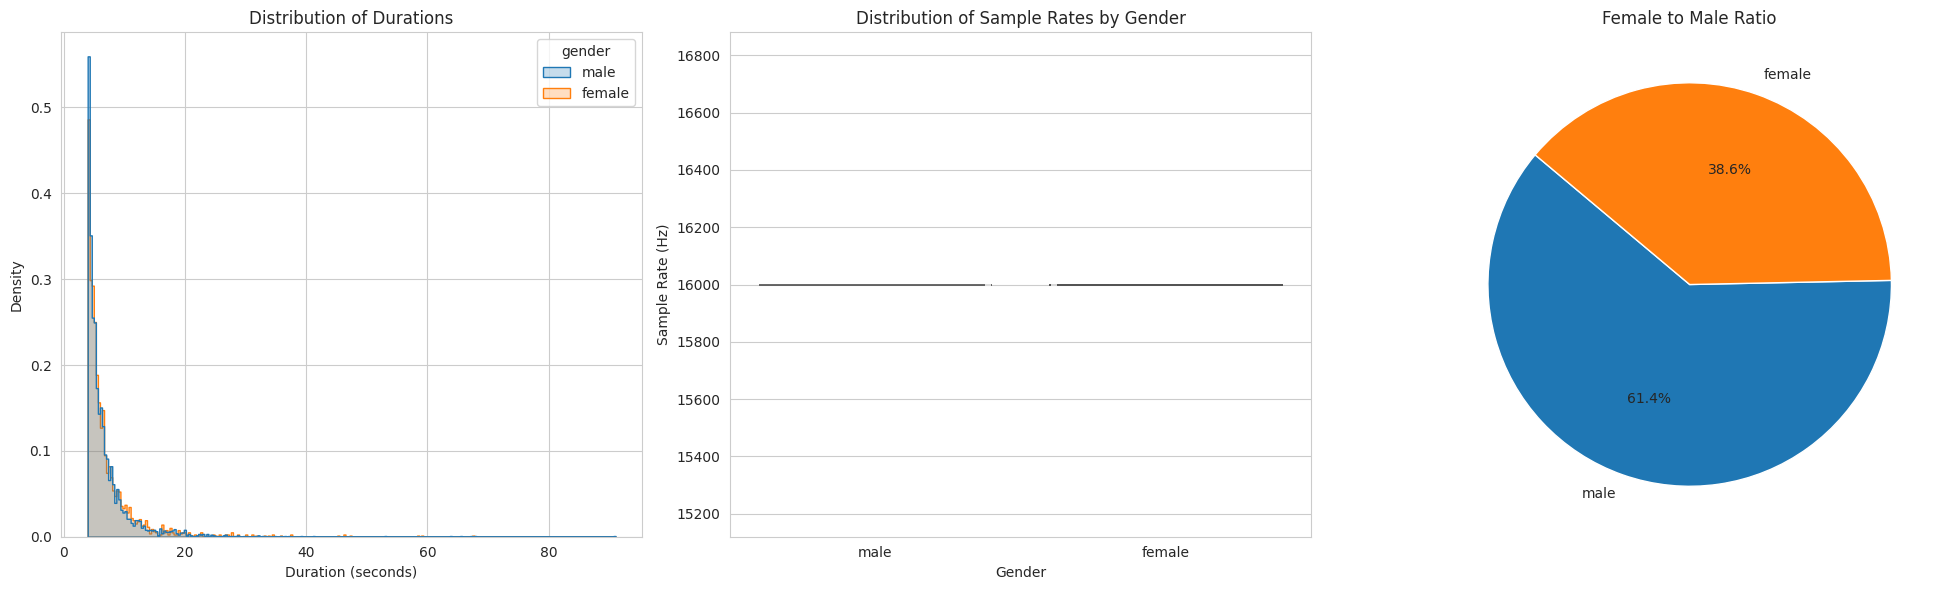

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the dataset
df = pd.read_csv('audio_files_info.csv')

# Display the first few rows of the dataframe
print(df.head())

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot distribution of durations
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.histplot(data=df, x="duration_seconds", hue="gender", element="step", stat="density", common_norm=False)
plt.title('Distribution of Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Density')

# Plot distribution of sample rates using a violin plot
plt.subplot(1, 3, 2)
sns.violinplot(data=df, x="gender", y="sampling_rate", palette="muted", split=True)
plt.title('Distribution of Sample Rates by Gender')
plt.xlabel('Gender')
plt.ylabel('Sample Rate (Hz)')

# Calculate female to male ratio and plot a pie chart
gender_counts = df['gender'].value_counts()
plt.subplot(1, 3, 3)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Female to Male Ratio')

plt.tight_layout()
plt.show()



#Deep Learning Approach

In [ ]:
import librosa
import numpy as np
import os
import pandas as pd

def extract_audio_features(audio_path, sr=22050, frame_length=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        if not np.any(y):
            return [0] * 107  # Adjusted for 107 features
    except Exception as e:
        print(f"Could not load {audio_path}. Error: {e}")
        return [0] * 107

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length, n_fft=frame_length)
    mfcc_delta = librosa.feature.delta(mfcc)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    pitches = pitches[magnitudes > np.median(magnitudes)]

    features = []

    if pitches.size > 0:
        pitch_mean = np.mean(pitches)
        pitch_median = np.median(pitches)
        pitch_std = np.std(pitches)
    else:
        pitch_mean, pitch_median, pitch_std = 0, 0, 0

    features += [pitch_mean, pitch_median, pitch_std]

    for mfcc_feature, delta_feature in zip(mfcc, mfcc_delta):
        features += [
            np.mean(mfcc_feature), np.std(mfcc_feature),
            np.min(mfcc_feature), np.max(mfcc_feature),
            np.mean(delta_feature), np.std(delta_feature),
            np.min(delta_feature), np.max(delta_feature)
        ]

    return features

def get_features_and_labels(data_dir):
    data = []
    for class_label, gender in enumerate(['males', 'females']):
        folder_path = os.path.join(data_dir, gender)
        for filename in os.listdir(folder_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(folder_path, filename)
                try:
                    features = extract_audio_features(file_path)
                    data.append(features + [class_label])
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    # Dynamically generate column names
    mfcc_cols = [f'mfcc_{i}_{stat}' for i in range(1, 14) for stat in ['mean', 'std', 'min', 'max']]
    delta_cols = [f'delta_{i}_{stat}' for i in range(1, 14) for stat in ['mean', 'std', 'min', 'max']]
    pitch_cols = ['pitch_mean', 'pitch_median', 'pitch_std']
    columns = mfcc_cols + delta_cols + pitch_cols + ['label']

    df = pd.DataFrame(data, columns=columns)
    return df

# Specify your data directory


df = get_features_and_labels(Data)

output_file = 'audio_features.csv'
df.to_csv(output_file, index=False)

print(f'Feature extraction complete. Output saved to {output_file}')

Feature extraction complete. Output saved to audio_features.csv


In [ ]:
# Load the dataset
df = pd.read_csv('audio_features.csv')

# Prepare data
X = df.drop('label', axis=1)
y = df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gaussian NB": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Initialize variables to track the best model
best_classifier_name = None
best_classifier_score = -np.inf

# Evaluate classifiers
for name, clf in classifiers.items():
    # Compute cross-validation score
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    mean_score = scores.mean()
    std_score = scores.std()
    print(f"{name} accuracy (+/-) {std_score*2:.2f}")
    print(f"Average accuracy: {mean_score:.4f}\n")

    # Update best classifier
    if mean_score > best_classifier_score:
        best_classifier_name = name
        best_classifier_score = mean_score

# Define a hard voting classifier
voting_clf = VotingClassifier(estimators=[
    (name, clf) for name, clf in classifiers.items()
], voting='hard')

voting_scores = cross_val_score(voting_clf, X_train, y_train, cv=5)
voting_mean_score = voting_scores.mean()
voting_std_score = voting_scores.std()
print(f"Hard Voting accuracy (+/-) {voting_std_score*2:.2f}")
print(f"Average accuracy: {voting_mean_score:.4f}\n")

# Compare Voting Classifier with the best model so far
if voting_mean_score > best_classifier_score:
    best_classifier_name = "Hard Voting"
    best_classifier_score = voting_mean_score

# Train and evaluate the best classifier
if best_classifier_name != "Hard Voting":
    best_classifier = classifiers[best_classifier_name]
    best_classifier.fit(X_train, y_train)
    y_pred = best_classifier.predict(X_val)
else:
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_val)

# Compute and print classification report for the best classifier
print(f"Best classifier: {best_classifier_name}")
report = classification_report(y_val, y_pred)
print(report)


Decision Tree accuracy (+/-) 0.01
Average accuracy: 0.7843

Gaussian NB accuracy (+/-) 0.01
Average accuracy: 0.8786

AdaBoost accuracy (+/-) 0.02
Average accuracy: 0.8815

Gradient Boosting accuracy (+/-) 0.02
Average accuracy: 0.8976

K Nearest Neighbors accuracy (+/-) 0.03
Average accuracy: 0.6957

Random Forest accuracy (+/-) 0.02
Average accuracy: 0.8976

SVM accuracy (+/-) 0.03
Average accuracy: 0.7626

Hard Voting accuracy (+/-) 0.02
Average accuracy: 0.8915

Best classifier: Gradient Boosting
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       743
           1       0.89      0.84      0.87       456

    accuracy                           0.90      1199
   macro avg       0.90      0.89      0.89      1199
weighted avg       0.90      0.90      0.90      1199



In [ ]:
import os
import torch
from torch.utils.data import Dataset
import torchaudio
 """
        Args:
            root_dir (string): Directory with all the audio folders ('Male' and 'Female').
            target_sample_rate (int): Target sample rate for all audio files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
class AudioDataset(Dataset):
    def __init__(self, root_dir, target_sample_rate, transform , device ):

        self.root_dir = root_dir
        self.target_sample_rate = target_sample_rate
        self.duration = 4  # Duration in seconds
        self.num_samples = self.target_sample_rate * self.duration
        self.device = device
        self.transform = transform.to(self.device)
        self.samples = []
        self.class_names = ['males', 'females']

        class_counts = {class_name: 0 for class_name in self.class_names}

        for class_name in self.class_names:
          class_dir = os.path.join(self.root_dir, class_name)
          class_counts[class_name] = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])

        min_count = min(class_counts.values())
        # Load dataset
        for index, class_name in enumerate(self.class_names):
          class_dir = os.path.join(self.root_dir, class_name)
          loaded_samples = 0  # Track number of loaded samples for this class
          for wav_file in os.listdir(class_dir):
            if loaded_samples < min_count:  # Only add up to min_count instances per class
              self.samples.append({
                      'audio_path': os.path.join(class_dir, wav_file),
                      'label': index  # 0 for Male, 1 for Female
                  })
              loaded_samples += 1
            else:
              break

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._ensure_fixed_length(signal)
        if self.transform:
            signal = self.transform(signal)
        return signal, label

    def _get_audio_sample_path(self, index):
        return self.samples[index]['audio_path']

    def _get_audio_sample_label(self, index):
        return self.samples[index]['label']

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _ensure_fixed_length(self, signal):
        # Cut if necessary
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        # Right pad if necessary
        elif signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    def get_class_distribution(self):
        # Initialize a dictionary to hold the count of each class
        class_distribution = {class_name: 0 for class_name in self.class_names}
        # Loop through all samples and increment the count for each class
        for sample in self.samples:
            label = sample['label']  # 0 for 'Male', 1 for 'Female'
            class_name = self.class_names[label]
            class_distribution[class_name] += 1
        return class_distribution


In [ ]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
if torch.cuda.is_available():
        device = "cuda"
else:
        device = "cpu"
print(f"Using device {device}")
dataset = AudioDataset(root_dir=Data, target_sample_rate = SAMPLE_RATE, transform=mel_spectrogram , device = device)
# traildataset = AudioDataset(root_dir=TestData, target_sample_rate = SAMPLE_RATE, transform=mel_spectrogram , device = device)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(f"There are {(len(train_dataset))} samples in the dataset.")
print(f"There is {dataset.get_class_distribution()}")


Using device cpu
There are 3697 samples in the dataset.
There is {'males': 2311, 'females': 2311}


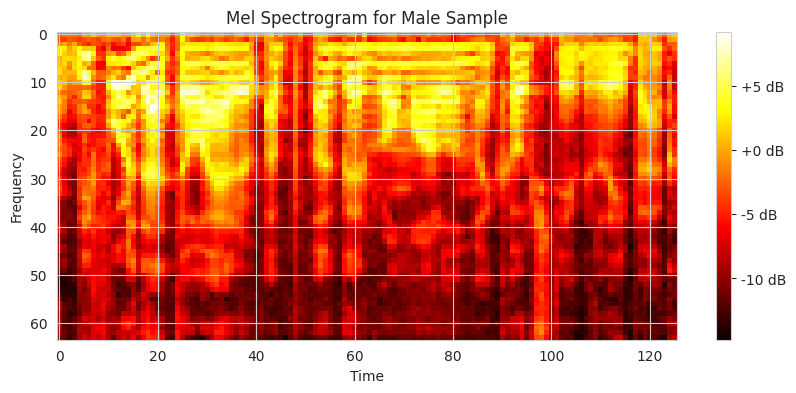

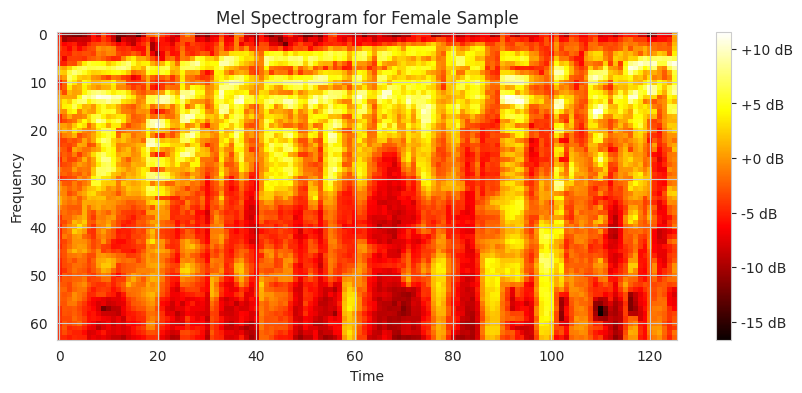

In [ ]:
# Function to visualize Mel Spectrogram
def visualize_mel_spectrogram(samples, title):
    plt.figure(figsize=(10, 4))
    for signal in samples:
        # Convert to Mel Spectrogram and visualize
        plt.imshow(signal.log2().cpu().numpy(), cmap='hot', aspect='auto')
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.colorbar(format='%+2.0f dB')
        plt.show()

# Visualize Mel Spectrograms for the found samples

visualize_mel_spectrogram(dataset[0][0], 'Mel Spectrogram for Male Sample')

visualize_mel_spectrogram(dataset[3000][0], 'Mel Spectrogram for Female Sample')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioClassifierCNN(nn.Module):
    def __init__(self):
        super(AudioClassifierCNN, self).__init__()
        # Adjusting for input spectrogram size of (64, 126)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling reduces size by half

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # After passing through four pooling layers:
        # Height dimension: 64 / 2^4 = 4
        # Width dimension: 126 / 2^4 = 7.875, which is practically considered as 7 (since dimensions are integer)
        self.fc1 = nn.Linear(128 * 4 * 7, 512)
        self.fc2 = nn.Linear(512, 2)  # Final output layer

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # Apply pooling after dropout

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # Apply pooling after dropout

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)  # Apply pooling after dropout

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)  # Apply pooling after dropout

        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 128 * 4 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
from torch.utils.data import DataLoader
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
def create_data_loader(train_data, batch_size,shuffle):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    return train_dataloader

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Seaborn's heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def run_epoch(model, data_loader, loss_fn, optimizer, device, is_train):
    if is_train:
        model.train()
    else:
        model.eval()

    correct = 0
    total = 0
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.set_grad_enabled(is_train):
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            # Save predictions and targets for calculating additional metrics
            all_predictions.extend(predicted.view(-1).cpu().numpy())
            all_targets.extend(targets.view(-1).cpu().numpy())

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # Calculate additional metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')
    confusion = confusion_matrix(all_targets, all_predictions)

    epoch_loss = total_loss / len(data_loader)
    epoch_accuracy = 100 * correct / total

    return epoch_loss, epoch_accuracy, precision, recall, f1, confusion


import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, loss_fn, optimizer, device, epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    # Additional metrics
    train_precisions = []
    train_recalls = []
    train_f1s = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training phase
        train_loss, train_accuracy, train_precision, train_recall, train_f1, _ = run_epoch(
            model, train_loader, loss_fn, optimizer, device, is_train=True)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)

        # Validation phase
        val_loss, val_accuracy, val_precision, val_recall, val_f1, val_confusion = run_epoch(
            model, val_loader, loss_fn, optimizer, device, is_train=False)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        # Log the metrics
        print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        print("---------------------------")

    print("Finished training")

    # Plotting training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

    class_names = ['Males', 'Females']
    plot_confusion_matrix(val_confusion, class_names)


AudioClassifierCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3584, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)
Epoch 1/30
Training - Loss: 0.8483, Accuracy: 54.29%, Precision: 0.5427, Recall: 0.5424, F1: 0.5419
Valid

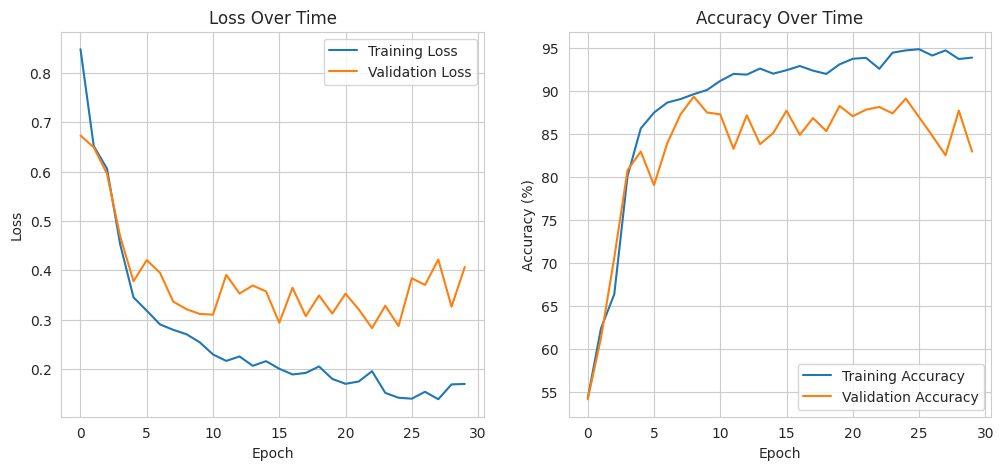

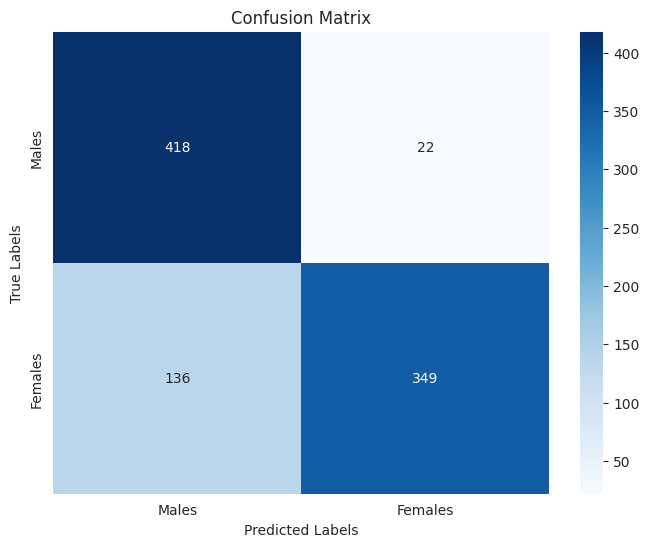

Trained feed forward net saved at feedforwardnet.pth


In [ ]:
train_loader = create_data_loader(train_dataset,BATCH_SIZE , True)
val_loader = create_data_loader(val_dataset,BATCH_SIZE , False)
    # construct model and assign it to device
cnn = AudioClassifierCNN().to(device)
print(cnn)

    # initialise loss funtion + optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE , weight_decay=0.01)


    # train model
train(cnn, train_loader,val_loader, loss_fn, optimiser, device, EPOCHS)

    # save model
torch.save(cnn.state_dict(), "feedforwardnet.pth")
print("Trained feed forward net saved at feedforwardnet.pth")

#Trail using a different dataset

In [ ]:
class_mapping = [
 "Male",
 "Female"
]

def predict(model, input, target, class_mapping):
    #model = model.to(torch.device('cuda'))
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected



In [ ]:
cnn = AudioClassifierCNN()
state_dict = torch.load("/content/voice_gender_detection/feedforwardnet.pth")
cnn.load_state_dict(state_dict)
inputs, targets = traildataset[8][0], traildataset[8][1] # [batch size, num_channels, fr, time]
inputs.unsqueeze_(0)
    # make an inference
predicted, expected = predict(cnn, inputs, targets,
                                  class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

NameError: name 'traildataset' is not defined